I_b = 0.34 ± 0.17
Rcsf = 12.48 ± 0.28
E = 0.54 ± 0.14
P_0 = 9.84 ± 2.25
File 100 / 1141


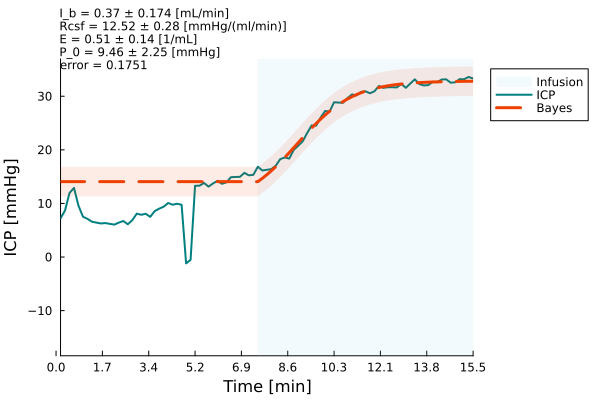

In [25]:
# Markov Chain Monte Carlo Maximum Likelihood Estimation
# Bayesian Model Comparison
# Currently, bounds imposed by sigmoid regularization of the optimised variables

using HDF5, EzXML, Glob, Dates, Plots, Optim, Symbolics, JuMP, StatsBase, DataFrames, CSV, Random, Distributions, Printf
using CurveFit
include("/Users/jjc/CSF/CSF Dynamics Scripts/readCSF.jl")

datapath = "/Users/jjc/CSF/Recordings/"
path = pwd();
savepath = "/Users/jjc/CSF/"
files = glob("*.hdf5", datapath);

global df = DataFrame(filename=files, Rcsf=NaN, E=NaN, Ib=NaN, P0=NaN, mode=NaN, error=NaN, R2=NaN, Pss=NaN, Rcsf_std=NaN, E_std=NaN, P0_std=NaN, Ib_std=NaN)

# for j = eachindex(files)
# for j  = 1:1000
# 990 good, 1141 good, 200 good
# for j = 1:length(files)
for j = 100
    # j in [278, 442, 521, 621, 676, 708, 755, 989, 1010, 1041, 1042, 1043] ? (continue) : 0 # Some recordings do not have summaries data saved

    filename = files[j]

    try
        global Data = readCSF(filename)
    catch
        continue
    end

    length(Data["ICP"]) > Data["infusion_end_frame"] ? (global Pm = Data["ICP"][Data["infusion_start_frame"]:Data["infusion_end_frame"]]) : (global Pm = Data["ICP"][Data["infusion_start_frame"]:end])
    global tslength = minimum([Data["infusion_end_frame"], length(Data["ICP"])])

    global D = Pm # Data

    global lb = [0.01, 0.01, -10.0, 0.1]
    global ub = [50.0, 1.0, Data["P_b"], 0.9]
    Ib_lower = lb[4]
    Ib_upper = ub[4]

    x0 = [sigmoid(Data["Rcsf"], lb[1], ub[1]), sigmoid(Data["E"], lb[2], ub[2]), sigmoid(Data["P_0"], lb[3], ub[3])]

    θ₁ = zeros(3)
    # θ₁ = x0
    try 
    y = solvemodel(θ₁...)
    catch
        continue
    end
    y = y[Data["infusion_start_frame"]:end]

    σ = 1.0 # standard deviation for the model 
    χ₁ = sum((D .- y) .^ 2) / (2 * σ^2) #

    total_n = 100000 # Number of iterations
    burntime = 20000 # Burn time

    # total_n = 1000000 # Number of iterations
    # burntime = 100000 # Burn time
    # a = [10.35, 0.14, 10.54] # Guess standard deviation
    # a = zeros(3) .+ 0.1 # Guess standard deviation for the parameters
    a = zeros(3) .+ 0.1 # Guess standard deviation for the parameters = how wide around the current guess we want to deviate [0.01 good], higher = exploration, lower = exploitation
    # TODO: consider adding a different one to the I_b convergence to bounds

    global thetasave = zeros(3, total_n - burntime)
    global thetasave_t = zeros(3, total_n - burntime)
    global chisave = zeros(total_n - burntime)

    for i = 1:total_n

        θ₂ = θ₁ .+ a .* randn(3) # Normal distribution

        Rcsf = sigmoid(θ₁[1], lb[1], ub[1])
        E = sigmoid(θ₁[2], lb[2], ub[2])
        P_0 = sigmoid(θ₁[3], lb[3], ub[3])
        I_b = (Data["P_b"] - P_0) / Rcsf

        while (I_b < lb[4]) || (I_b > ub[4])
            θ₂ = θ₁ .+ a .* randn(3) # Normal distribution
            Rcsf = sigmoid(θ₂[1], lb[1], ub[1])
            E = sigmoid(θ₂[2], lb[2], ub[2])
            P_0 = sigmoid(θ₂[3], lb[3], ub[3])
            I_b = (Data["P_b"] - P_0) / Rcsf
        end

        y = solvemodel(θ₂...)
        y = y[Data["infusion_start_frame"]:end]
        χ₂ = sum((D .- y) .^ 2) / (2 * σ^2)

        ratio = exp((-χ₂ + χ₁) / 2 * σ^2) # Likelihood ratio
        r = rand(1)[1] # Uniform distribution

        if r < ratio
            θ₁ = θ₂
            χ₁ = χ₂
        end

        ths = zeros(3)
        if i > burntime
            ths[1] = sigmoid(θ₁[1], lb[1], ub[1])
            ths[2] = sigmoid(θ₁[2], lb[2], ub[2])
            ths[3] = sigmoid(θ₁[3], lb[3], ub[3])
            thetasave[:, i-burntime] = θ₁
            thetasave_t[:, i-burntime] .= ths
            chisave[i-burntime] = χ₁
        end
    end

    # thetasave_t = thetasave

    Ib_all = zeros(total_n - burntime)
    global Ib_all .= (Data["P_b"] .- thetasave_t[3, :]) ./ thetasave_t[1, :]
    # global Ib_all .= (Data["P_b"] .- Data["P_0"]) ./ thetasave_t[1, :]

    println(@sprintf("I_b = %0.2f ± %0.2f", median(Ib_all), std(Ib_all)))
    println(@sprintf("Rcsf = %0.2f ± %0.2f", median(thetasave_t[1,:]), std(thetasave_t[1,:])))
    println(@sprintf("E = %0.2f ± %0.2f", median(thetasave_t[2,:]), std(thetasave_t[2,:])))
    println(@sprintf("P_0 = %0.2f ± %0.2f", median(thetasave_t[3,:]), std(thetasave_t[3,:])))

    opt_idx = findmin(chisave)[2]
    Rcsf = sigmoid(thetasave[1, opt_idx], lb[1], ub[1])
    E = sigmoid(thetasave[2, opt_idx], lb[2], ub[2])
    P_0 = sigmoid(thetasave[3, opt_idx], lb[3], ub[3])
    I_b = (Data["P_b"] - P_0) / Rcsf

    df.Rcsf[j] = (round(mean(thetasave_t[1, :]), digits=2))
    df.P0[j] = (round(mean(thetasave_t[3, :]), digits=2))
    df.Ib[j] = (round(mean(Ib_all), digits=2))
    df.E[j] = (round(mean(thetasave_t[2, :]), digits=2))
    df.filename[j] = filename[length(datapath)+2:end]
    df.error[j] = round(calc_model_plot(I_b, E, P_0)[2], digits=3)
    # global Pm = solvemodel(Rcsf, E, P_0)
    length(Data["ICP"]) > Data["infusion_end_frame"] ? (global Pm = Data["ICP"][Data["infusion_start_frame"]:Data["infusion_end_frame"]]) : (global Pm = Data["ICP"][Data["infusion_start_frame"]:end])
    global tslength = minimum([Data["infusion_end_frame"], length(Data["ICP"])])
    volRes, pressRes, fitted_curve, R2, MSE = press_vol_curve(Rcsf, P_0)
    df.R2[j] = round(R2, digits=3)
    df.Rcsf_std[j] = (round(std(thetasave_t[1, :]), digits=2))
    df.E_std[j] = (round(std(thetasave_t[2, :]), digits=2))
    df.P0_std[j] = (round(std(thetasave_t[3, :]), digits=2))
    df.Ib_std[j] = (round(std(Ib_all), digits=2))
    println("File $j / $(length(files))")
    # CSV.write("/Users/jjc/CSF/Results/Results_BayesSTD.csv", df)
end
# CSV.write("/Users/jjc/CSF/Results/Results_BayesSTD.csv", df)
μ = mean(thetasave_t, dims=2)
σ = std(thetasave_t, dims=2)

opt_idx = findmin(chisave)[2]
Rcsf = sigmoid(thetasave[1, opt_idx], lb[1], ub[1])
E = sigmoid(thetasave[2, opt_idx], lb[2], ub[2])
P_0 = sigmoid(thetasave[3, opt_idx], lb[3], ub[3])

# Rcsf = sigmoid(mean(thetasave[1,:]), lb[1], ub[1])
# E = sigmoid(mean(thetasave[2,:]), lb[2], ub[2])
# P_0 = sigmoid(mean(thetasave[3,:]), lb[3], ub[3])
I_b = (Data["P_b"] - P_0) / Rcsf
rmserr = calc_model_plot(I_b, E, P_0)[2]
h0 = plotmodel(I_b, E, P_0, μ, σ, "dar", "")
title!("I_b = $(round(I_b,digits=2)) ± $(round(std(Ib_all),digits=3)) [mL/min]\n" * "Rcsf = $(round(value(Rcsf),digits=2)) ± $(round(std(thetasave_t[1,:]),digits=2)) [mmHg/(ml/min)]\n" * "E = $(round(value(E),digits=2)) ± $(round(std(thetasave_t[2,:]),digits=2)) [1/mL]\n" * "P_0 = $(round(value(P_0),digits=2)) ± $(round(std(thetasave_t[3,:]),digits=2)) [mmHg]\n" * "error = $rmserr", titlealign=:left, titlefontsize=8, xlabel="Time [min]", ylabel="ICP [mmHg]")

# icmp_curve = calc_model_plot((Data["P_b"]-Data["P_0"])/Data["Rcsf"], Data["E"], Data["P_0"])[1]
# plot!(icmp_curve, lw=2, alpha=0.7, label="∇ descent")

In [10]:

# Rcsf = mean(thetasave_t[1,:])
# plotmodel(mean(Ib_all), mean(thetasave_t[2,:]), mean(thetasave_t[3,:]), "dark", "")
include("/Users/jjc/CSF/CSF Dynamics Scripts/readCSF.jl")




sigmoid (generic function with 1 method)

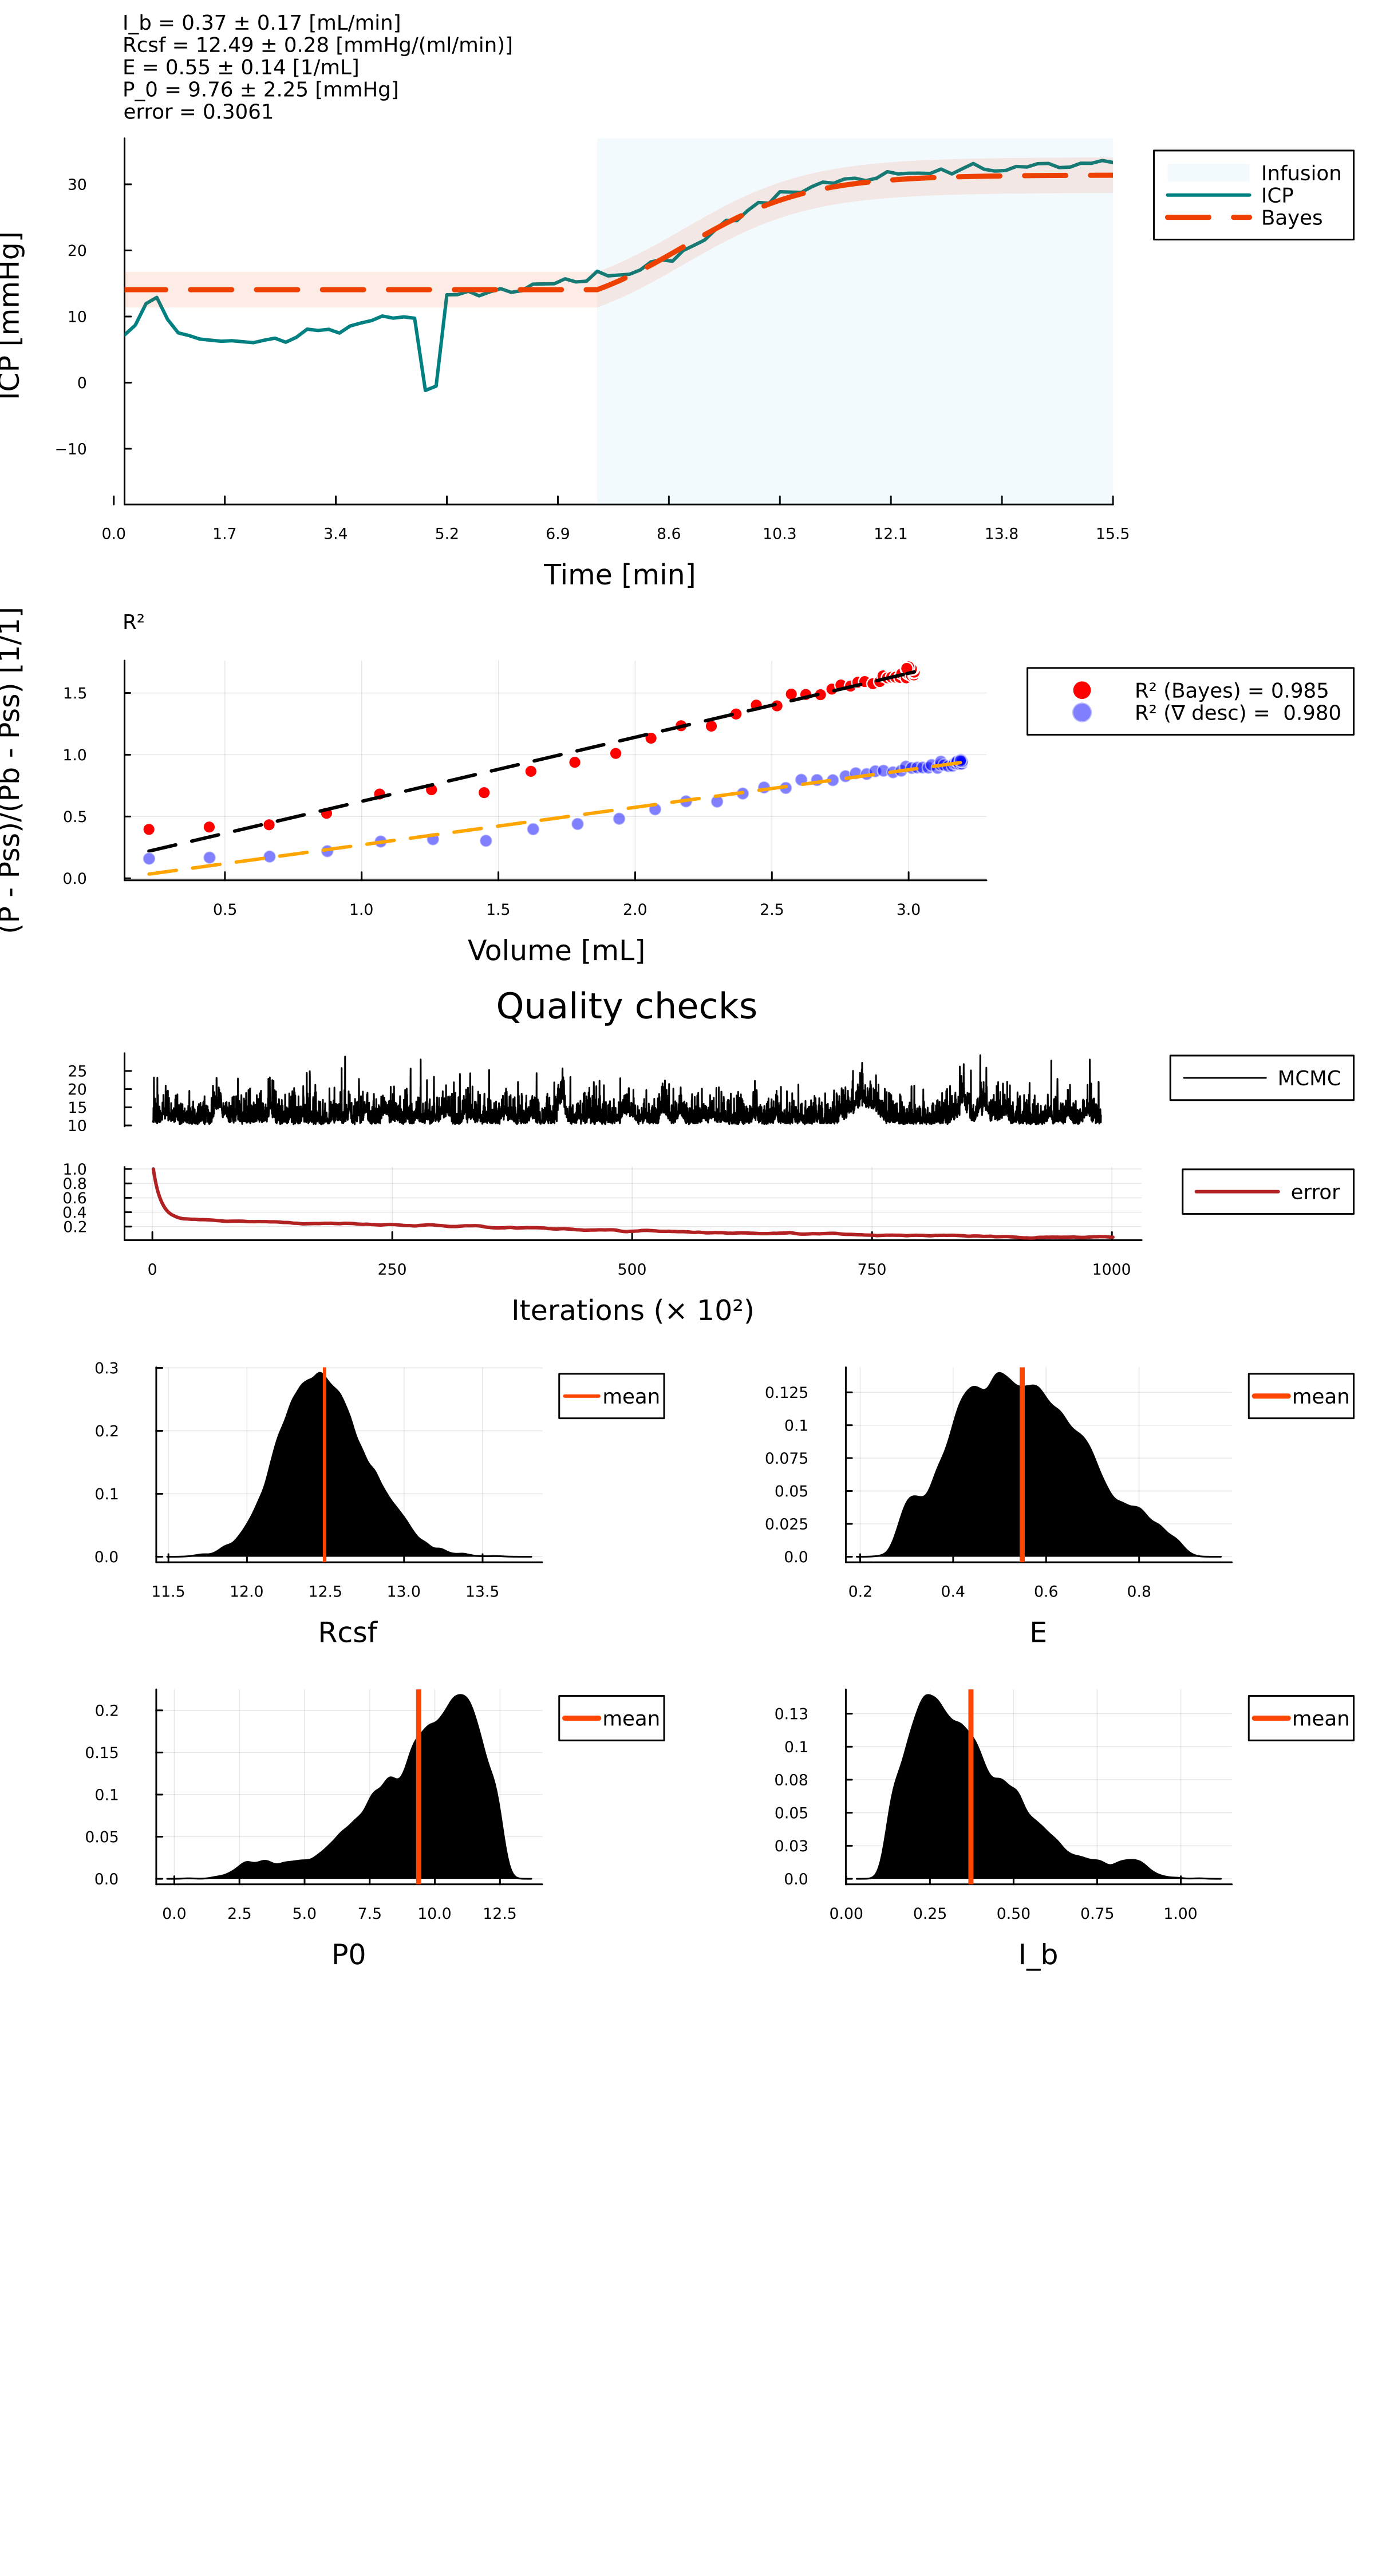

In [28]:
# Rcsf = mean(thetasave_t[1,:])
# plotmodel(mean(Ib_all), mean(thetasave_t[2,:]), mean(thetasave_t[3,:]), "dark", "")
using StatsPlots,Printf, LinearAlgebra
include("/Users/jjc/CSF/CSF Dynamics Scripts/readCSF.jl")

μ = mean(thetasave_t, dims=2)
σ = std(thetasave_t, dims=2)

Rcsf = sigmoid(mean(thetasave[1,:]), lb[1], ub[1])
E = sigmoid(mean(thetasave[2,:]), lb[2], ub[2])
P_0 = sigmoid(mean(thetasave[3,:]), lb[3], ub[3])
I_b = mean(Ib_all)

# Rcsf = sigmoid(StatsBase.mode(thetasave_t[1, :]), lb[1], ub[1])
# E = sigmoid(StatsBase.mode(thetasave_t[2, :]), lb[2], ub[2])
# P_0 = sigmoid(StatsBase.mode(thetasave_t[3, :]), lb[3], ub[3])
# I_b = StatsBase.mode(Ib_all)

rmserr = calc_model_plot(I_b, E, P_0)[2]
h0 = plotmodel(I_b, E, P_0, μ, σ, "dar", "")
title!("I_b = $(@sprintf("%.2f", I_b)) ± $(@sprintf("%.2f",std(Ib_all))) [mL/min]\n" * "Rcsf = $(@sprintf("%.2f", Rcsf)) ± $(round(std(thetasave_t[1,:]),digits=2)) [mmHg/(ml/min)]\n" * "E = $(round(value(E),digits=2)) ± $(round(std(thetasave_t[2,:]),digits=2)) [1/mL]\n" * "P_0 = $(round(value(P_0),digits=2)) ± $(round(std(thetasave_t[3,:]),digits=2)) [mmHg]\n" * "error = $rmserr", titlealign=:left, titlefontsize=8, xlabel="Time [min]", ylabel="\n ICP [mmHg]")

# Plot ICM+ curve
# icmp_curve = calc_model_plot((Data["P_b"]-Data["P_0"])/Data["Rcsf"], Data["E"], Data["P_0"])[1]
# plot!(icmp_curve, lw=2, alpha=0.7, label="∇ descent")

# CSV.write("/Users/jjc/CSF/Results/Results_BayesSTD.csv", df)

R_bayes = Rcsf
R_icm = Data["Rcsf"]
P0_bayes = P_0
P0_icm = Data["P_0"]
nr=1

bayescol=:red
icmcol=:blue
bgcolor=:white

# plotmodel overrides global Pm for some reason causing a conflict - have to change it back to Pm
Pm = D
volRes, pressRes, fitted_curve, R2, MSE = press_vol_curve(R_bayes[nr], P0_bayes[nr])

h00 = plot(volRes, log.(pressRes), seriestype=:scatter, makersize=5, color=bayescol, markerstrokewidth=0.5, markerstrokecolor=bgcolor, linewidth=1, label= @sprintf("R² (Bayes) = %.3f", R2), grid=true, titlefontsize=8, titlealign=:left, background=bgcolor, xlabel="Volume [mL]", ylabel="(P - Pss)/(Pb - Pss) [1/1]")
plot!(volRes, fitted_curve, lw=2, linecolor=:black, linestyle=:dash, legend=:outertopright, label="")

volRes, pressRes, fitted_curve, R2, MSE = press_vol_curve(R_icm[nr], P0_icm[nr])
plot!(volRes, log.(pressRes), seriestype=:scatter, alpha=0.5, makersize=5, color=icmcol, markerstrokewidth=0.5, markerstrokecolor=bgcolor, linewidth=1, 
label="$(@sprintf("R² (∇ desc) =  %.3f", R2))", grid=true, titlefontsize=8, titlealign=:left, background=bgcolor, xlabel="Volume [mL]", ylabel="(P - Pss)/(Pb - Pss) [1/1]")
plot!(volRes, fitted_curve, lw=2, linecolor=:orange, linestyle=:dash, legend=:outertopright, label="")
title!("R²")

opt_idx = findmin(chisave)[2]

h1 = plot(chisave[1:10:end], linecolor=:black, label="MCMC", xaxis=false, xticks=[], title="Quality checks", grid=false,legend=:outertopright)

acf = autocor(chisave, collect(0:1000), demean=true)

h2 = plot(acf,label="error", xlabel="Iterations (× 10²)", lw=2, linecolor=:firebrick,legend=:outertopright)

h3 = density(thetasave_t[1,:],label="", fillrange=0, color=:black, legend=:outertopright)
# b= plotattr(:Series,"nbins")
ytk = parse.(Float64, yticks(h3)[1][2])
hist_fit = Distributions.fit(Histogram, thetasave_t[1,:])
hist_fit = LinearAlgebra.normalize(hist_fit, mode=:probability)
fac = sum(hist_fit.weights.*diff(hist_fit.edges[1]))
h03 = plot(hist_fit)
# ytk_norm = parse.(Float64, yticks(h03)[1][2])
vline!(h3, [mean(thetasave_t[1,:])],lw=2,label="mean", linecolor=:orangered, xlabel="Rcsf", yticks=(ytk, round.(ytk.*fac,digits=5)), ylabel="\n\n")
# vline!(h3, [thetasave_t[1,opt_idx]],lw=2,label="Max L(θ)", linecolor=:teal,legend=:outertopright)
# vspan!(h3, [mean(thetasave_t[1,:])-std(thetasave_t[1,:]),mean(thetasave_t[1,:])+std(thetasave_t[1,:])],lw=3,label="std", linecolor=:transparent, alpha=0.1, color=:orangered, xlims=[0,50])

h4 = density(thetasave_t[2,:],label="", fillrange=0, color=:black, legend=:outertopright)
ytk = parse.(Float64, yticks(h4)[1][2])
hist_fit = Distributions.fit(Histogram, thetasave_t[2,:])
hist_fit = LinearAlgebra.normalize(hist_fit, mode=:probability)
fac = sum(hist_fit.weights.*diff(hist_fit.edges[1]))
vline!(h4, [mean(thetasave_t[2,:])],lw=3,label="mean", linecolor=:orangered, xlabel="E", yticks=(ytk, round.(ytk.*fac,digits=5)), ylabel="\n\n")
# vline!(h4, [thetasave_t[2,opt_idx]],lw=2,label="Max L(θ)", linecolor=:teal,legend=:outertopright)
# vspan!(h4, [mean(thetasave_t[2,:])-std(thetasave_t[2,:]),mean(thetasave_t[2,:])+std(thetasave_t[2,:])],lw=3,label="std", linecolor=:transparent, alpha=0.1, color=:orangered)

h5 = density(thetasave_t[3,:],label="", fillrange=0, color=:black, legend=:outertopright)
ytk = parse.(Float64, yticks(h5)[1][2])
hist_fit = Distributions.fit(Histogram, thetasave_t[3,:])
hist_fit = LinearAlgebra.normalize(hist_fit, mode=:probability)
fac = sum(hist_fit.weights.*diff(hist_fit.edges[1]))
vline!(h5, [mean(thetasave_t[3,:])],lw=3,label="mean", linecolor=:orangered, xlabel="P0", yticks=(ytk, round.(ytk.*fac,digits=2)), ylabel="\n\n")
# vline!(h5, [thetasave_t[3,opt_idx]],lw=2,label="Max L(θ)", linecolor=:teal,legend=:outertopright)
# vspan!(h5, [mean(thetasave_t[3,:])-std(thetasave_t[3,:]),mean(thetasave_t[3,:])+std(thetasave_t[3,:])],lw=3,label="std", linecolor=:transparent, alpha=0.1, color=:orangered)

# h6 = histogram(Ib_all,nbins=100, label="", xlabel="I_f",color=:black)
h6 = density(Ib_all,label="", fillrange=0, color=:black, legend=:outertopright)
ytk = parse.(Float64, yticks(h6)[1][2])
hist_fit = Distributions.fit(Histogram, Ib_all)
hist_fit = LinearAlgebra.normalize(hist_fit, mode=:probability)
fac = sum(hist_fit.weights.*diff(hist_fit.edges[1]))
vline!(h6, [mean(Ib_all)],lw=3,label="mean", linecolor=:orangered, xlabel="I_b", yticks=(ytk, round.(ytk.*fac,digits=2)), ylabel="\n\n")
# vline!(h6, [Ib_all[opt_idx]],lw=2, label="Max L(θ)", linecolor=:teal,legend=:outertopright)
# vspan!(h6, [mean(Ib_all)-std(Ib_all),mean(Ib_all)+std(Ib_all)],lw=3,label="std", linecolor=:transparent, alpha=0.1, color=:orangered, xlims=[0,1])

plot(h0, h00, h1, h2, h3, h4, h5, h6, layout=[grid(4,1, heights=[.5,.3,.1,.1]),grid(2,2, heights=[.2, .2, .2, .2])], size=(800,1500), dpi=300, tickfontsize=6)


# savefig("qchecks1.png")


# ylims(h6)